# Analyzing with iNNvestigate

**iNNvestigate** got created to make analyzing neural network's predictions easy! The library should help the user to focus on research and development by providing implemented analysis methods and facilitating rapid development of new methods. In this notebook we will show you how to use **iNNvestigate** and for a better understanding we recommend to read [iNNvestigate neural networks!](https://jmlr.org/papers/v20/18-540.html) first! How to use **iNNvestigate** you can read in this notebook: [Developing with iNNvestigate](introduction_development.ipynb)

-----

**The intention behind iNNvestigate is to make it easy to use analysis methods, but it is not to explain the underlying concepts and assumptions. Please, read the according publication(s) when using a certain method and when publishing please cite the according paper(s) (as well as the [iNNvestigate paper](https://jmlr.org/papers/v20/18-540.html)). Thank you!** You can find most related publication in [iNNvestigate neural networks!](https://jmlr.org/papers/v20/18-540.html) and in the README file.

### Analysis methods

The field of analyizing neural network's predictions is about gaining insights how and why a potentially complex network gave as output a certain value or choose a certain class over others. This is often called interpretability or explanation of neural networks. We just call it analyzing a neural network's prediction to be as neutral as possible and to leave any conclusions to the user.

Most methods have in common that they analyze the input features w.r.t. a specific neuron's output. Which insights a method reveals about this output can be grouped into (see [Learning how to explain: PatternNet and PatternAttribution](https://arxiv.org/abs/1705.05598)):

* **function:** analyzing the operations the network function uses to extract or compute the output. E.g., how would changing an input feature change the output.
* **signal:** analyzing the components of the input that cause the output. E.g., which parts of an input image or which directions of an input are used to determine the output.
* **attribution:** attributing the "importance" of input features for the output. E.g., how much would changing an input feature change the output.

----

In this notebook we will introduce methods for each of these categories and along show how to use different features of **iNNvestigate**, namely how to:

* analyze a prediction.
* train an analyzer.
* analyze a prediction w.r.t to a specific output neuron.

Let's dive right into it!

### Run on Colab
> Colab uses per default tensorflow 1.15 which was not used for development of `iNNvestigate`  
> Switch to colab GPU runtime for performance

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/albermax/innvestigate/blob/master/examples/notebooks/introduction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>



In [1]:
import os

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
    if not os.path.exists("/content/innvestigate"):
        !git clone https://github.com/albermax/innvestigate.git
        !pip install /content/innvestigate --no-deps
    %cd /content/innvestigate/examples/notebooks
except Exception:
    IS_COLAB = False


### Training a network

To analyze a network, we need a network! As a base for **iNNvestigate** we chose the Keras deep learning library, because it is easy to use and allows to inspect build models.

In this first piece of code we import all the necessary modules:

In [2]:
import warnings

warnings.simplefilter("ignore")

In [3]:
%matplotlib inline

import imp
import os

import matplotlib.pyplot as plot
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

tf.compat.v1.disable_eager_execution()

import innvestigate

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils.mnist as mnistutils

In [4]:
innvestigate.__version__

'2.0.0'

to load the data:

In [5]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(
    x_train, input_range
)

# Preprocess data
data = (
    preprocess(x_train),
    y_train,
    preprocess(x_test),
    y_test,
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

and to now create and train a CNN model:

In [6]:
# Create & train model
input_shape = (28, 28, 1)

model = keras.models.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

scores = mnistutils.train_model(model, data, batch_size=128, epochs=10)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 34s 566us/sample - loss: 0.1395 - accuracy: 0.9591
Epoch 2/10
60000/60000 [==============================] - 35s 587us/sample - loss: 0.0371 - accuracy: 0.9882
Epoch 3/10
60000/60000 [==============================] - 37s 621us/sample - loss: 0.0213 - accuracy: 0.9930
Epoch 4/10
60000/60000 [==============================] - 41s 682us/sample - loss: 0.0152 - accuracy: 0.9950
Epoch 5/10
60000/60000 [==============================] - 40s 670us/sample - loss: 0.0095 - accuracy: 0.9969
Epoch 6/10
60000/60000 [==============================] - 42s 699us/sample - loss: 0.0074 - accuracy: 0.9977
Epoch 7/10
60000/60000 [==============================] - 42s 693us/sample - loss: 0.0073 - accuracy: 0.9976
Epoch 8/10
60000/60000 [==============================] - 43s 711us/sample - loss: 0.0073 - accuracy: 0.9975
Epoch 9/10
60000/60000 [==============================] - 45s 746us/sample - loss: 0.0058 - accuracy: 0.9

## Analyzing a predicition

Let's first choose an image to analyze:

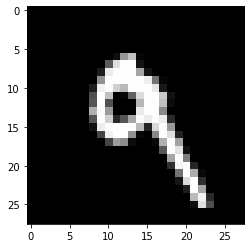

In [7]:
# Choosing a test image for the tutorial:
image = data[2][7:8]

plot.imshow(image.squeeze(), cmap="gray", interpolation="nearest")
plot.show()

In this first part we show how to create and use an analyzer. To do so we use an analyzer from *function* category, namely the gradient. The gradient shows how the linearized network function reacts on changes of a single feature.

This is simply done by passing the model without a softmax to the analyzer class:

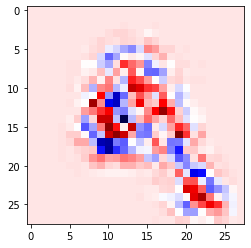

In [8]:
# Stripping the softmax activation from the model
model_wo_sm = innvestigate.model_wo_softmax(model)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Displaying the gradient
plot.imshow(analysis.squeeze(), cmap="seismic", interpolation="nearest")
plot.show()

For convience there is a function that creates an analyzer for you. It passes all the parameter on to the class instantiation:

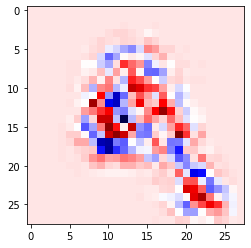

In [9]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Displaying the gradient
plot.imshow(analysis.squeeze(), cmap="seismic", interpolation="nearest")
plot.show()

To emphasize different compontents of the analysis many people use instead of the "plain" gradient the absolute value or the square of it. With the gradient analyzer this can be done specifying additional parameters when creating the analyzer:

In [10]:
# Creating a parameterized analyzer
abs_gradient_analyzer = innvestigate.create_analyzer(
    "gradient", model_wo_sm, postprocess="abs"
)
square_gradient_analyzer = innvestigate.create_analyzer(
    "gradient", model_wo_sm, postprocess="square"
)

Similar other analyzers can be parameterized.

Now we visualize the result by projecting the gradient into a gray-color-image:

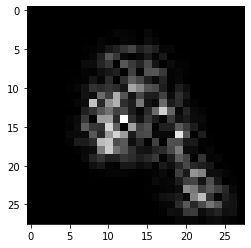

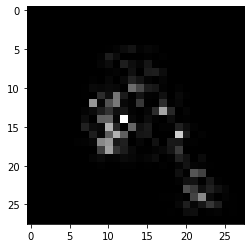

In [11]:
# Applying the analyzers
abs_analysis = abs_gradient_analyzer.analyze(image)
square_analysis = square_gradient_analyzer.analyze(image)

# Displaying the analyses, use gray map as there no negative values anymore
plot.imshow(abs_analysis.squeeze(), cmap="gray", interpolation="nearest")
plot.show()
plot.imshow(square_analysis.squeeze(), cmap="gray", interpolation="nearest")
plot.show()

## Choosing the output neuron

In the previous examples we always analyzed the output of the neuron with the highest activation. In the next one we show how one can choose the neuron to analyze:

In [12]:
# Creating an analyzer and set neuron_selection_mode to "index"
inputXgradient_analyzer = innvestigate.create_analyzer(
    "input_t_gradient", model_wo_sm, neuron_selection_mode="index"
)

The gradient\*input analyzer is an example from the *attribution* category and we visualize it by means of a colored heatmap to highlight positive and negative attributions:

Analysis w.r.t. to neuron 0


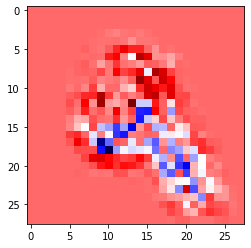

Analysis w.r.t. to neuron 1


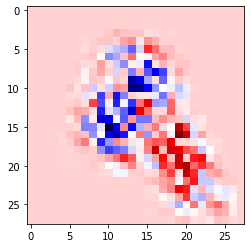

Analysis w.r.t. to neuron 2


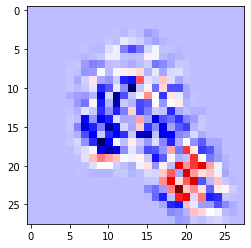

Analysis w.r.t. to neuron 3


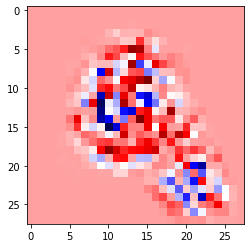

Analysis w.r.t. to neuron 4


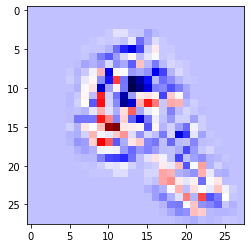

Analysis w.r.t. to neuron 5


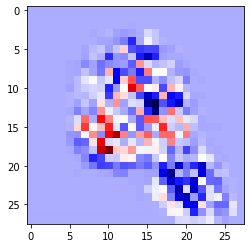

Analysis w.r.t. to neuron 6


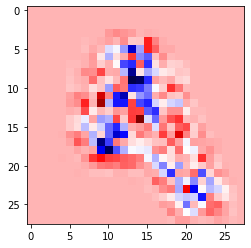

Analysis w.r.t. to neuron 7


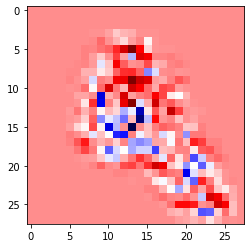

Analysis w.r.t. to neuron 8


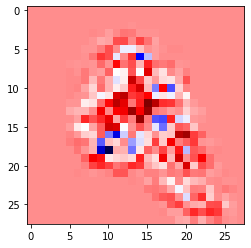

Analysis w.r.t. to neuron 9


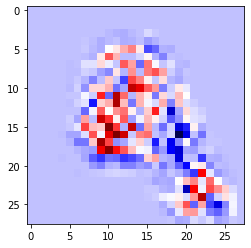

In [13]:
for neuron_index in range(10):
    print("Analysis w.r.t. to neuron", neuron_index)
    # Applying the analyzer and pass that we want
    analysis = inputXgradient_analyzer.analyze(image, neuron_index)

    # Displaying the gradient
    plot.imshow(analysis.squeeze(), cmap="seismic", interpolation="nearest")
    plot.show()

## Additional resources

If you would like to learn more we have more notebooks for you, for example: [Comparing methods on MNIST](mnist_method_comparison.ipynb), [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)

If you want to know more about how to use the API of **iNNvestigate** look into: [Developing with iNNvestigate](introduction_development.ipynb)